# Информационная безопасность

Предоставлены данные, собранные с помощью специальной программы по информационной безопасности.   
  
**Цель проекта:** разработать модель, которая будет максимально качественно классифицировать трафик на нормальный и злонамеренный.   

**Ход работы:**  
    1. Изучение общей информации о данных;  
    2. Предобработка данных - проверка на дубликаты, пропуски, аномалии;  
    3. Проведение исследовательского анализа данных - классов, распределения, корреляций;  
    4. Деление на выборки, кодирование категориальных данных.  
    5. Построить модели многоклассовой классификации и сравнить их метрики.  
    6. Протестировать и проанализировать модель с лучшими метриками.

In [1]:
pip install skimpy

     |████████████████████████████████| 18.2 MB 1.5 MB/s eta 0:00:01�████████████       | 14.2 MB 1.5 MB/s eta 0:00:03
     |████████████████████████████████| 1.2 MB 27.9 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 4.1 MB/s  eta 0:00:01
     |████████████████████████████████| 239 kB 92.8 MB/s eta 0:00:01
     |████████████████████████████████| 27.6 MB 44 kB/s s eta 0:00:01 | 23.1 MB 56.8 MB/s eta 0:00:01MB 56.8 MB/s eta 0:00:01
     |████████████████████████████████| 12.3 MB 16.6 MB/s eta 0:00:01
     |████████████████████████████████| 154 kB 51.9 MB/s eta 0:00:01
     |████████████████████████████████| 40.1 MB 77 kB/s s eta 0:00:01██████████████▏          | 26.5 MB 80.9 MB/s eta 0:00:01
     |████████████████████████████████| 83 kB 2.5 MB/s  eta 0:00:01
     |████████████████████████████████| 283 kB 51.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 64.9 MB/s eta 0:00:01
     |████████████████████████████████| 341 kB 34.1 MB/s eta 0:00:01
     |███

In [26]:
#импортирование библиотек

import pandas as pd
import numpy as np
from skimpy import clean_columns

import matplotlib.pyplot as plt

import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings("ignore")

## Общая информация о данных

In [7]:
#загрузка данных

df = pd.read_csv('network_traffic_data.csv')

In [10]:
df.head(10)

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,80,5480074,3,1,12,0,6,0,4.000,3.465,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,443,711977,9,10,703,3950,267,0,78.100,103.300,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,53,153398,2,2,80,224,40,40,40.000,0.000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,53,57660,1,1,46,128,46,46,46.000,0.000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,8446,767,3,1,43,6,31,6,14.336,14.440,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
5,47210,3,2,0,0,0,0,0,0.000,0.000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
6,53,111373,4,2,168,116,42,42,42.000,0.000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
7,443,65786373,122,191,23544,275883,1093,0,193.000,366.200,...,20,14600467.0,0.0,14600467,14600467,51185856.0,0.0,51185854,51185854,BENIGN
8,1877,213,3,1,43,6,31,6,14.336,14.440,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
9,53,91552,1,1,54,179,54,54,54.000,0.000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [9]:
#приведение названий признаков к стилю snake

df = clean_columns(df)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539616 entries, 0 to 539615
Data columns (total 79 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   destination_port             539616 non-null  int64  
 1   flow_duration                539616 non-null  int64  
 2   total_fwd_packets            539616 non-null  int64  
 3   total_backward_packets       539616 non-null  int64  
 4   total_length_of_fwd_packets  539616 non-null  int64  
 5   total_length_of_bwd_packets  539616 non-null  int64  
 6   fwd_packet_length_max        539616 non-null  int64  
 7   fwd_packet_length_min        539616 non-null  int64  
 8   fwd_packet_length_mean       539616 non-null  float64
 9   fwd_packet_length_std        539616 non-null  float64
 10  bwd_packet_length_max        539616 non-null  int64  
 11  bwd_packet_length_min        539616 non-null  int64  
 12  bwd_packet_length_mean       539616 non-null  float64
 13 

-Значения признаков численное, за исключением целевого - label.  
-Обнаружены пропуски в flow_bytes_s - в 488 строках, примерно 0,1% всей выборки. О природе данных ничего не известно, о причинах пропусков можно только догадываться.  

## Предобработка данных и EDA

In [12]:
#проверка на дубликаты

df.duplicated().sum()

64601

In [13]:
#удаление дубликатов

df = df.drop_duplicates()

In [14]:
#переменные для признаков и целевого признака 

target = df['label']
features = df.drop('label', axis=1)

In [15]:
#статистический анализ

#настройка отображения чисел

pd.options.display.float_format ='{:,.2f}'.format
pd.set_option('display.max_columns', None)

features.describe()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes_s,flow_packets_s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets_s,bwd_packets_s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down_up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length_1,fwd_avg_bytes_bulk,fwd_avg_packets_bulk,fwd_avg_bulk_rate,bwd_avg_bytes_bulk,bwd_avg_packets_bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
count,"475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","474,975.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00","475,015.00"
mean,"5,871.02","23,929,532.77",6.73,6.73,461.76,"9,086.72",191.16,12.21,49.46,67.56,"1,902.18",26.08,624.18,792.09,inf,inf,"2,423,083.12","5,980,251.38","19,671,222.13","332,600.23","23,576,720.84","4,583,366.51","7,573,115.86","19,537,199.31","1,174,198.36","10,907,150.42","2,304,229.02","2,741,266.30","7,342,882.47","925,165.85",0.04,0.00,0.00,0.00,"-5,225.62","-4,875.46","29,304.43","7,369.88",10.59,"1,956.37",313.06,617.29,"1,263,461.13",0.07,0.04,0.00,0.38,0.34,0.06,0.00,0.00,0.67,345.28,49.46,624.18,"-5,225.62",0.00,0.00,0.00,0.00,0.00,0.00,6.73,461.76,6.73,"9,085.57","7,786.90","1,449.67",3.33,"-2,763.93","131,205.95","45,866.71","190,039.08","102,046.87","18,290,434.59","1,088,927.62","19,165,971.16","17,483,818.10"
std,"15,516.41","39,778,408.85",367.82,494.00,"7,969.01","1,081,220.09",592.69,50.10,154.78,230.90,"2,958.79",58.07,901.83,"1,309.60",NaN,NaN,"6,143,912.02","11,053,189.53","35,546,012.81","4,538,847.15","39,802,879.23","11,210,483.34","14,596,757.51","35,624,844.85","9,523,629.29","29,680,702.33","9,605,994.35","9,519,425.49","23,225,804.18","8,196,948.63",0.19,0.00,0.01,0.00,"2,233,296.31","2,213,317.15","156,468.99","39,182.25",22.39,"2,976.06",429.98,939.34,"2,594,146.72",0.25,0.19,0.01,0.49,0.47,0.24,0.01,0.01,0.65,471.66,154.78,901.83,"2,233,296.31",0.00,0.00,0.00,0.00,0.00,0.00,367.82,"7,969.01",494.00,"1,080,551.37","13,647.21","7,006.37",285.12,"1,121,605.25","828,777.48","463,048.76","1,127,467.47","755,885.70","34,765,331.51","6,876,320.34","35,667,511.50","34,601,079.14"
min,0.00,-12.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"-12,000,000.00","-2,000,000.00",-12.00,0.00,-12.00,-13.00,0.00,0.00,0

- В некоторых признаках (bwd_psh_flags, bwd_urg_flags, fwd_avg_bytes_bulk, fwd_avg_packets_bulk, fwd_avg_bulk_rate, bwd_avg_bytes_bulk, bwd_avg_packets_bulk, bwd_avg_bulk_rate) не содержится информации, все значения в них - нули. За ненадобностью удаляются.  
- В признаках flow_bytes_s и flow_packets_s содержатся бесконечные значения, которые необходимо обработать для обучения модели

In [16]:
#подсчет количества бесконечных значений в числеенных признаках

col = [] #переменная-список признаков содержащих inf

for i in features.columns:
    if np.isinf(features[i]).sum() > 0:
        col.append(i)
        print(i , np.isinf(features[i]).sum())

flow_bytes_s 222
flow_packets_s 262


In [17]:
#замена inf на max+1 для каждого признака

for i in col:
    features = features.replace(np.inf, (features.loc[features[i]!= np.inf]).max()+1)

In [18]:
#удаление признаков, где одно уникальное значение

features = features.loc[:, features.nunique()>1]

In [19]:
#пропуски в flow_bytes_s, где минимальное значение -12000000, заменим заглушкой

features = features.fillna(-13000000)

label
BENIGN                        232809
DoS Hulk                       87251
DDoS                           64364
PortScan                       56397
DoS GoldenEye                  10286
FTP-Patator                     5933
DoS slowloris                   5385
DoS Slowhttptest                5228
SSH-Patator                     3219
Bot                             1953
Web Attack � Brute Force        1470
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64


<AxesSubplot:xlabel='label'>

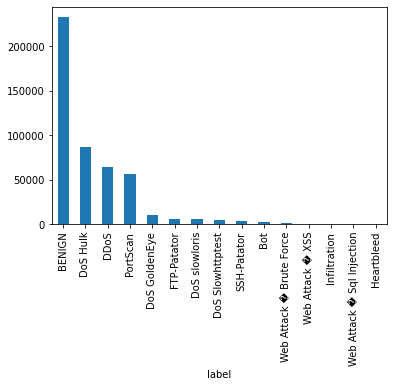

In [20]:
#подсчет классов в целевом признаке 

class_frequency = target.value_counts()
print(class_frequency)
class_frequency.plot(kind='bar')

Ярко выражен дисбаланс классов, наименее встречающиеся классы составлют десятитысячные доли относительно выборки.

In [21]:
features.corr()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes_s,flow_packets_s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,fwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets_s,bwd_packets_s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down_up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length_1,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
destination_port,1.00,-0.20,-0.00,-0.00,0.01,-0.00,0.08,-0.01,0.13,0.11,-0.24,-0.15,-0.26,-0.22,0.05,0.32,-0.13,-0.18,-0.18,-0.03,-0.20,-0.14,-0.17,-0.18,-0.04,-0.10,-0.07,-0.07,-0.08,-0.04,0.20,0.00,0.00,0.00,0.33,0.13,-0.14,-0.20,-0.22,-0.20,-0.15,-0.08,0.20,-0.00,-0.12,0.34,0.50,0.00,-0.00,0.06,-0.22,0.13,-0.26,0.00,-0.00,0.01,-0.00,-0.00,-0.08,0.20,-0.00,0.00,-0.05,-0.04,-0.05,-0.04,-0.18,-0.03,-0.18,-0.17
flow_duration,-0.20,1.00,0.02,0.01,0.05,0.01,0.24,-0.12,0.12,0.23,0.52,-0.24,0.52,0.47,-0.02,-0.13,0.57,0.86,0.90,0.07,1.00,0.64,0.85,0.90,0.17,0.64,0.39,0.49,0.53,0.18,-0.03,-0.00,-0.00,-0.00,-0.11,-0.11,-0.25,0.52,0.45,0.47,0.29,0.34,-0.03,-0.00,-0.17,0.23,-0.13,-0.00,-0.00,-0.25,0.43,0.12,0.52,-0.00,0.02,0.05,0.01,0.01,-0.09,-0.06,0.01,-0.00,0.18,0.18,0.24,0.13,0.88,0.27,0.90,0.84
total_fwd_packets,-0.00,0.02,1.00,1.00,0.23,1.00,0.01,-0.00,0.00,0.00,0.01,-0.01,0.01,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.02,-0.00,0.00,0.00,-0.00,0.02,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.01,0.01,0.01,0.01,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.01,0.00,0.01,0.00,1.00,0.23,1.00,1.00,0.01,0.00,0.81,-0.00,0.01,0.01,0.02,0.01,0.00,0.00,0.00,0.00
total_backward_packets,-0.00,0.01,1.00,1.00,0.22,1.00,0.01,-0.00,0.00,0.00,0.01,-0.00,0.01,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.01,-0.00,-0.00,0.00,-0.00,0.02,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.01,0.01,0.01,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.01,0.00,0.01,0.00,1.00,0.22,1.00,1.00,0.00,-0.00,0.81,-0.00,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00
total_length_of_fwd_packets,0.01,0.05,0.23,0.22,1.00,0.19,0.21,-0.00,0.21,0.17,0.00,-0.02,0.00,-0.00,0.00,-0.01,-0.00,0.01,0.01,-0.00,0.05,0.00,0.01,0.01,-0.01,0.07,0.01,0.02,0.03,0.00,0.01,-0.00,0.00,0.00,-0.01,-0.01,-0.02,0.04,0.04,0.03,0.01,-0.00,0.01,0.00,0.03,-0.00,-0.00,-0.00,0.00,-0.01,0.04,0.21,0.00,0.00,0.23,1.00,0.22,0.19,0.03,0.01,0.28,0.00,0.07,0.09,0.10,0.04,0.01,0.01,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
active_min,-0.04,0.13,0.01,0.01,0.04,0.01,0.04,-0.03,0.03,0.04,0.03,-0.06,0.03,0.03,-0.01,-0.03,0.10,0.09,0.09,0.00,0.13,0.05,0.07,0.09,-0.01,0.01,0.00,0.01,0.01,-0.01,-0.01,-0.00,-0.00,-0.00,-0.03,-0.03,-0.06,0.04,0.01,0.03,0.02,-0.03,-0.01,-0.00,0.08,-0.01,-0.02,-0.00,-0.00,-0.10,0.01,0.03,0.03,-0.00,0.01,0.04,0.01,0.01,0.10,0.00,0.01,-0.00,0.92,0.01,0.68,1.00,0.08,0.08,0.09,0.06
idle_mean,-0.18,0.88,0.00,0.00,0.01,0.00,0.17,-0.11,0.09,0.18,0.57,-0.21,0.59,0.53,-0.02,-0.11,0.59,0.94,0.99,0.07,0.88,0.69,0.94,0.98,0.20,0.41,0.36,0.49,0.54,0.17,-0.04,-0.00,-0.00,-0.00,-0.1

Среди некоторых признаков заметна большая корреляция, с этим необходимо было бы поработать при использовании модели логистической регрессии. Для других моделей так же можно было бы провести эксперимент с удалением зависимых между собой признаков для экономии времени.

## Подбор и сравнение моделей

In [22]:
#деление на тренировочную и тестовую выборки

#выделение тренировочной части в соотношении 75% и 25%
features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size=0.25, random_state=12345, stratify=target)

print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(356261, 70)
(118754, 70)
(356261,)
(118754,)


In [23]:
#кодирование таргета 

le = LabelEncoder()
target_train_le = le.fit_transform(target_train)
target_test_le = le.transform(target_test)

print(target_train_le.shape)
print(target_test_le.shape)

(356261,)
(118754,)


In [24]:
#построение baseline'a

model_1 = RandomForestClassifier(random_state=12345, class_weight='balanced')
tar_pred_1 = cross_val_predict(model_1, features_train, target_train_le, cv=5, n_jobs=-1)
print(classification_report(target_train_le, tar_pred))
print(accuracy_score(target_train_le, tar_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    174607
           1       0.96      0.95      0.95      1465
           2       1.00      1.00      1.00     48273
           3       1.00      1.00      1.00      7714
           4       1.00      1.00      1.00     65438
           5       1.00      0.99      1.00      3921
           6       1.00      0.99      0.99      4039
           7       1.00      1.00      1.00      4450
           8       1.00      0.88      0.93         8
           9       1.00      0.56      0.71        27
          10       1.00      1.00      1.00     42298
          11       1.00      1.00      1.00      2414
          12       0.73      0.80      0.76      1102
          13       0.43      0.19      0.26        16
          14       0.43      0.31      0.36       489

    accuracy                           1.00    356261
   macro avg       0.90      0.84      0.86    356261
weighted avg       1.00   

In [27]:
model_2 = CatBoostClassifier(loss_function='MultiClass', random_seed=12345, verbose=0)
tar_pred_2 = cross_val_predict(model_2, features_train, target_train_le, cv=5, n_jobs=-1, verbose=0)
print(classification_report(target_train_le, tar_pred_2))
print(accuracy_score(target_train_le, tar_pred_2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    174607
           1       0.95      0.97      0.96      1465
           2       1.00      1.00      1.00     48273
           3       1.00      1.00      1.00      7714
           4       1.00      1.00      1.00     65438
           5       1.00      0.99      0.99      3921
           6       0.99      0.99      0.99      4039
           7       1.00      1.00      1.00      4450
           8       1.00      0.88      0.93         8
           9       1.00      0.67      0.80        27
          10       1.00      1.00      1.00     42298
          11       1.00      1.00      1.00      2414
          12       0.73      0.87      0.80      1102
          13       0.75      0.38      0.50        16
          14       0.52      0.29      0.38       489

    accuracy                           1.00    356261
   macro avg       0.93      0.87      0.89    356261
weighted avg       1.00   

In [ ]:
#словарь с параметрами для модели случайного леса

parametrs = { 'max_depth': range (2, 16, 2),
              'n_estimators': range (9, 150, 10) }

model_3 = RandomForestClassifier(random_state=12345, class_weight='balanced')

#подбор параметров модели 

grid = GridSearchCV(model_3, parametrs, scoring='accuracy', cv=5, n_jobs=-1)
tar_pred_3 = cross_val_predict(grid, features_train, target_train_le, cv=5, n_jobs=-1)

In [25]:
#вывод показателей случайного леса с подбором параметров

print(classification_report(target_train_le, tar_pred_3))
print(accuracy_score(target_train_le, tar_pred_3))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    174607
           1       0.54      0.99      0.70      1465
           2       1.00      1.00      1.00     48273
           3       0.99      1.00      0.99      7714
           4       1.00      1.00      1.00     65438
           5       0.99      0.99      0.99      3921
           6       1.00      0.99      1.00      4039
           7       1.00      1.00      1.00      4450
           8       1.00      0.88      0.93         8
           9       1.00      0.56      0.71        27
          10       1.00      1.00      1.00     42298
          11       0.99      1.00      0.99      2414
          12       0.69      0.54      0.61      1102
          13       0.16      0.56      0.24        16
          14       0.30      0.68      0.41       489

    accuracy                           0.99    356261
   macro avg       0.84      0.88      0.84    356261
weighted avg       0.99   

Подбор параметров случайного леса не дал прироста метрик. Из исследованных моделей лучшие показатели дала CatBoostClassifier(loss_function='MultiClass').

## Тестирование и анализ лучшей модели

In [32]:
best_model = CatBoostClassifier(loss_function='MultiClass', random_seed=12345, verbose=0)

best_model.fit(features_train, target_train, verbose=0)

In [33]:
pred = best_model.predict(features_test)
print(classification_report(target_test, pred))
print(accuracy_score(target_test, pred))

                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     58202
                       Bot       0.95      0.98      0.97       488
                      DDoS       1.00      1.00      1.00     16091
             DoS GoldenEye       1.00      1.00      1.00      2572
                  DoS Hulk       1.00      1.00      1.00     21813
          DoS Slowhttptest       1.00      0.99      0.99      1307
             DoS slowloris       0.99      0.99      0.99      1346
               FTP-Patator       1.00      1.00      1.00      1483
                Heartbleed       1.00      1.00      1.00         3
              Infiltration       1.00      0.89      0.94         9
                  PortScan       1.00      1.00      1.00     14099
               SSH-Patator       1.00      1.00      1.00       805
  Web Attack � Brute Force       0.74      0.88      0.80       368
Web Attack � Sql Injection       0.75      0.60

Обученная и протестированная модель показала метрику не ниже валидационной. Класс Web Attack � XSS предсказывается хуже всего - некоторые классы слишком малочисленны. 

In [45]:
#feature_importance

pd.set_option('display.max_rows', None)
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,destination_port,11.43
1,bwd_packet_length_std,8.62
2,psh_flag_count,7.27
3,avg_fwd_segment_size,6.98
4,init_win_bytes_forward,5.26
5,init_win_bytes_backward,4.77
6,fwd_iat_std,3.94
7,packet_length_std,3.31
8,min_seg_size_forward,2.89
9,flow_iat_min,2.78


По важности признаков видно, что почти все они нужны для предсказания и вносят вклад. В дальнейшей работе для ускорения можно было бы попробовать удалить последние 4 и сильно коррелирующие между собой признаки и проверить, как это скажется на качестве новой модели.

## Отчет по проделанной работе

1. Изучила общую информацию о данных - размер выборки и типы данных. Обнаружено, что значения признаков численное, за исключением целевого - label, обнаружены пропуски в flow_bytes_s - в 488 строках, примерно 0,1% всей выборки. О природе данных ничего не известно, о причинах пропусков рекомендуется проконсультироваться с разработчиками.
2. Выполнила предобработку данных - удаление явных дубликатов, удаление неинформативных признаков, замена бесконечных значений и пропусков. 
3. Анализ выборки показал дисбаланс в целевом признаке с 15 классами, наименее встречающиеся классы составлют десятитысячные доли относительно выборки.  
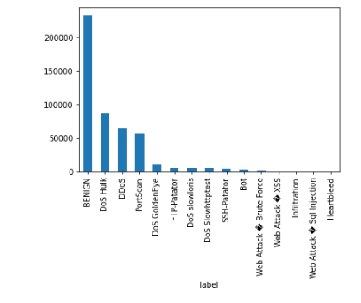
  
Среди некоторых признаков заметна большая корреляция.  
4. Разбила данные на выборки для обучения и теста с учетом баланса классов, закодировала таргет для требующих этого моделей. Модель RandomForestClassifier с параметрами по умолчанию и class_weight='balanced' на валидации вывела метрику accuracy 0.9966.  
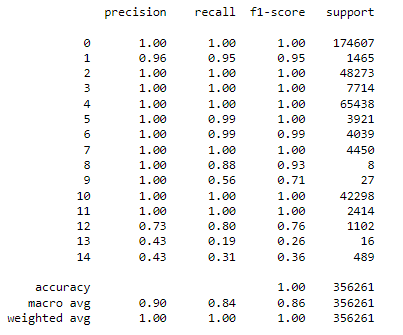
  
При этом при подборе параметров метрика стала хуже.   
Чуть лучший показатель получился у модели CatBoostClassifier(loss_function='MultiClass'), accuracy 0.9974.  
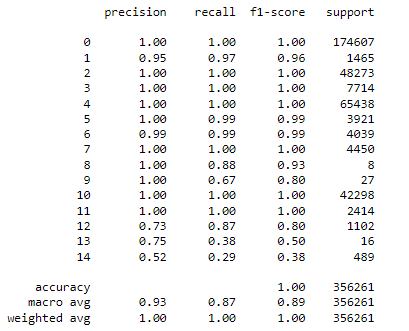
  
5. Протестировала модель и убедилась в ее эффективности, показатели метрик не стали ниже. Исследовала важность признаков - почти все они нужны для предсказания и вносят вклад. В дальнейшей работе для ускорения можно было бы попробовать удалить cwe_flag_count, fwd_urg_flags, rst_flag_count, ece_flag_count (показатели 0.00) и сильно коррелирующие между собой признаки и проверить, как это скажется на качестве новой модели.  

Тем самым была достигнута цель проекта - разработать модель, которая будет максимально качественно классифицировать трафик на нормальный и злонамеренный, решена задача многоклассовой классификации.